In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

In [4]:
# ============================================================================
# 1. LOAD AND COMBINE ALL DATASETS
# ============================================================================

print("=" * 70)
print("COMPREHENSIVE CLUSTERING DENDROGRAM ANALYSIS")
print("=" * 70)

print("\n1. Loading datasets...")

# Load sidechain angles data
print("   Loading sidechain angles data...")
sidechain_df = pd.read_csv("sidechain_angles.csv", index_col=0)

# Extract variant names from sample names
sidechain_df['variant'] = [sample.split('-S')[0] if '-S' in sample else sample for sample in sidechain_df.index]
sidechain_df = sidechain_df.reset_index().rename(columns={'index': 'sequence'})

# Handle missing values in angles
angle_cols = [col for col in sidechain_df.columns if any(col.endswith(suffix) for suffix in ['_Theta', '_Phi', '_Chi1'])]
sidechain_df[angle_cols] = sidechain_df[angle_cols].replace('N/A', np.nan).astype(float)
sidechain_df[angle_cols] = sidechain_df[angle_cols].fillna(sidechain_df[angle_cols].mean())

print(f"   Sidechain data shape: {sidechain_df.shape}")
print(f"   Angle features: {len(angle_cols)}")

# Load mutation data
print("   Loading mutation data...")
mutation_df = pd.read_csv("mutation/mutation-all.csv")
print(f"   Mutation data shape: {mutation_df.shape}")

# Load distance data
print("   Loading distance data...")
try:
    distance_df = pd.read_csv("tmalign/residues_full.csv")
    print(f"   Distance data shape: {distance_df.shape}")
except FileNotFoundError:
    print("   Distance data not found, proceeding without it")
    distance_df = None

# Combine datasets
print("\n2. Combining datasets...")
combined_df = sidechain_df.copy()

# Merge with mutation data
combined_df = combined_df.merge(mutation_df, on=['sequence', 'variant'], how='left')
print(f"   After merging mutation data: {combined_df.shape}")

# Merge with distance data if available
if distance_df is not None:
    combined_df = combined_df.merge(distance_df, on='sequence', how='left')
    print(f"   After merging distance data: {combined_df.shape}")

# Remove rows with missing data
combined_df = combined_df.dropna()
print(f"   Final combined dataset shape: {combined_df.shape}")

COMPREHENSIVE CLUSTERING DENDROGRAM ANALYSIS

1. Loading datasets...
   Loading sidechain angles data...
   Sidechain data shape: (49, 32)
   Angle features: 30
   Loading mutation data...
   Mutation data shape: (48, 70)
   Loading distance data...
   Distance data shape: (55, 223)

2. Combining datasets...
   After merging mutation data: (49, 100)
   After merging distance data: (49, 322)
   Final combined dataset shape: (48, 322)


In [5]:
# ============================================================================
# 2. EXTRACT FEATURES FOR CLUSTERING
# ============================================================================

print("\n3. Extracting features for clustering...")

# Define feature groups
feature_groups = {}

# Angle features
feature_groups['angles'] = angle_cols
print(f"   Angle features: {len(angle_cols)}")

# Mutation features (exclude sequence, variant, and 'Against' columns)
mutation_cols = [col for col in combined_df.columns 
                if col not in ['sequence', 'variant'] + angle_cols + 
                [col for col in combined_df.columns if col.startswith('Against')]]
feature_groups['mutations'] = mutation_cols
print(f"   Mutation features: {len(mutation_cols)}")

# Distance features (if available)
distance_cols = [col for col in combined_df.columns if col.startswith('residue_')]
if distance_cols:
    feature_groups['distances'] = distance_cols
    print(f"   Distance features: {len(distance_cols)}")
else:
    print("   No distance features found")

# Create feature matrix
all_features = []
feature_names = []

def clean_feature_name(name):
    """Clean feature name by removing special characters and spaces"""
    import re
    cleaned = re.sub(r'[^a-zA-Z0-9_]', '_', str(name))
    cleaned = re.sub(r'_+', '_', cleaned)
    cleaned = cleaned.strip('_')
    return cleaned

for group_name, cols in feature_groups.items():
    if cols:
        features = combined_df[cols].values.astype(float)
        all_features.append(features)
        # Create clean feature names
        for col in cols:
            clean_name = clean_feature_name(f"{group_name}_{col}")
            feature_names.append(clean_name)
        print(f"   Added {len(cols)} {group_name} features")

# Combine all features
X = np.hstack(all_features)
print(f"   Total features: {X.shape[1]}")


3. Extracting features for clustering...
   Angle features: 30
   Mutation features: 290
   Distance features: 222
   Added 30 angles features
   Added 290 mutations features
   Added 222 distances features
   Total features: 542



4. Creating comprehensive dendrogram analysis...
   Generating dendrogram for ward linkage...


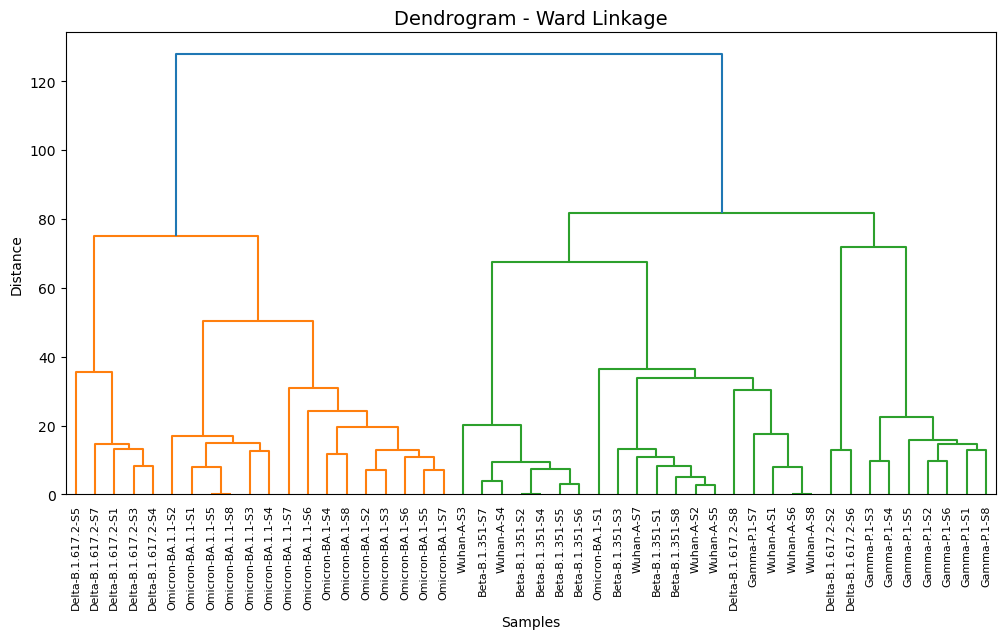

   Generating dendrogram for complete linkage...


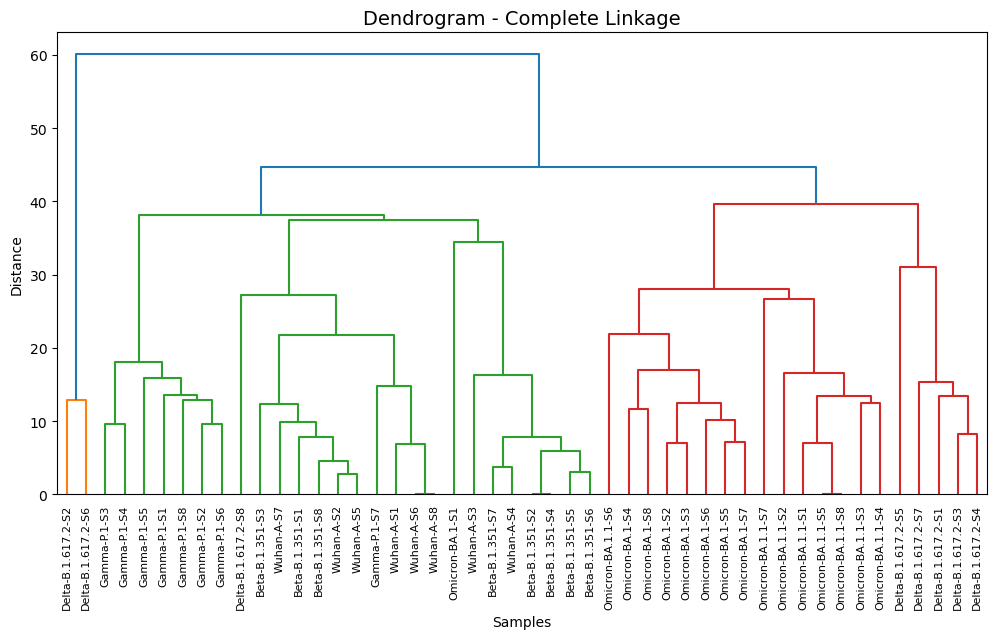

   Generating dendrogram for average linkage...


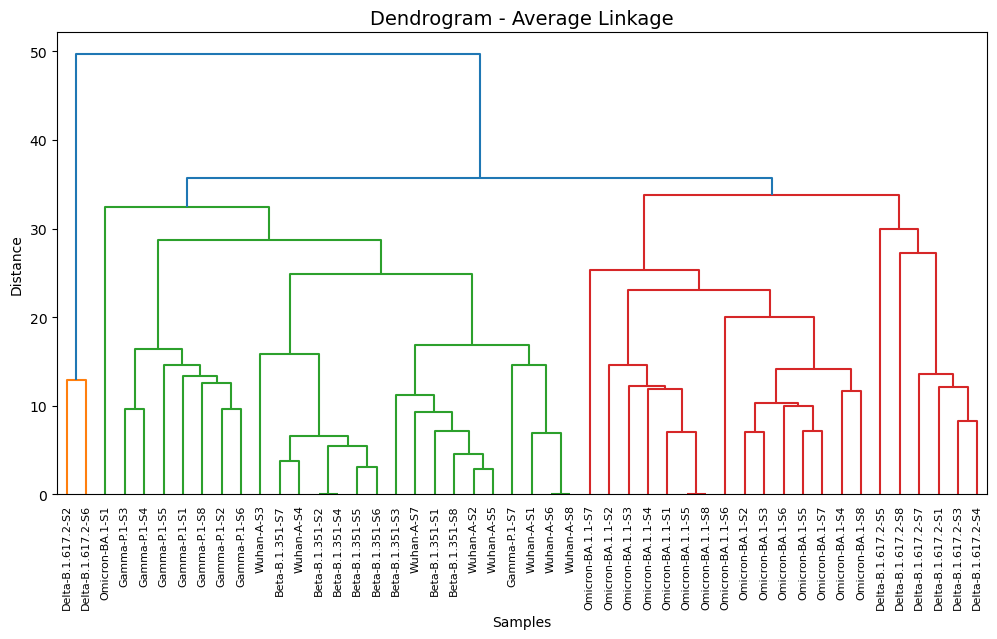

   Generating dendrogram for single linkage...


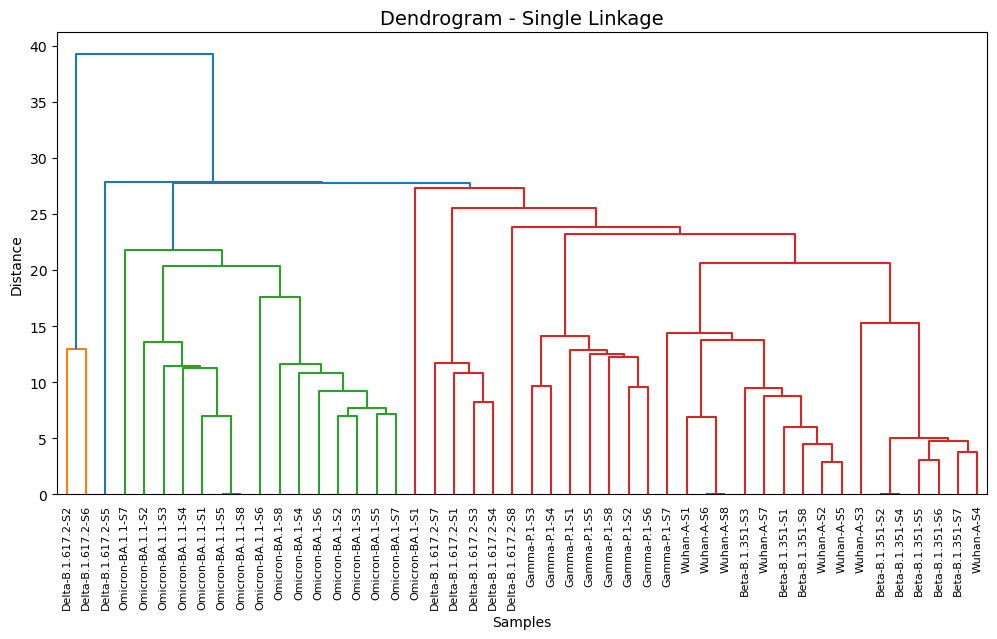

   Generating dendrogram for centroid linkage...


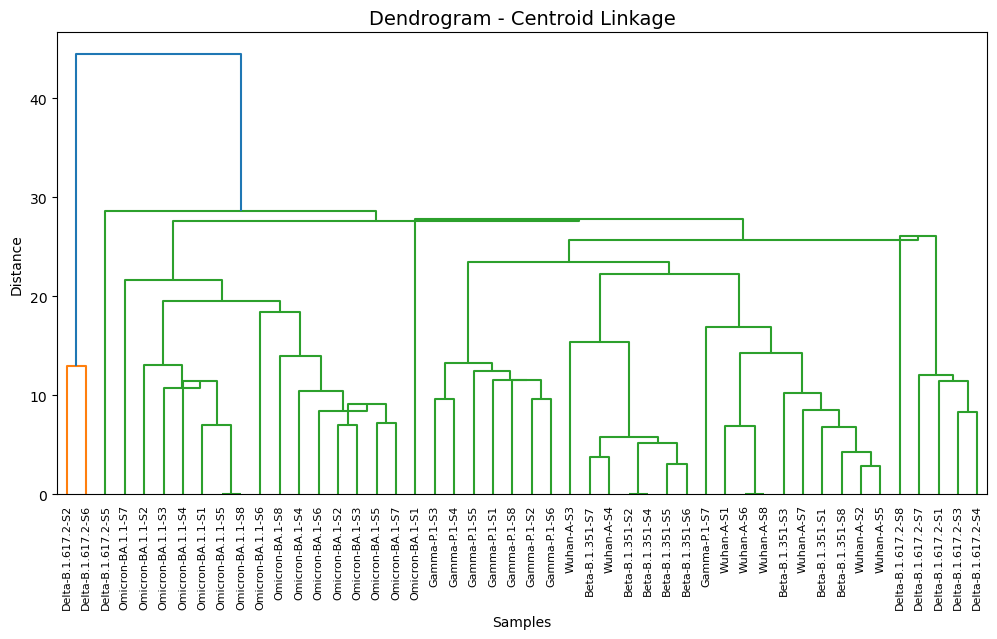

In [7]:
# ============================================================================
# 3. CREATE COMPREHENSIVE DENDROGRAM
# ============================================================================

print("\n4. Creating comprehensive dendrogram analysis...")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define linkage methods to test
linkage_methods = ['ward', 'complete', 'average', 'single', 'centroid']

for method in linkage_methods:
    print(f"   Generating dendrogram for {method} linkage...")
    try:
        # Calculate distance matrix and linkage
        distance_matrix = pdist(X_scaled, metric='euclidean')
        linkage_matrix = linkage(distance_matrix, method=method)
        
        # Create a new figure for each method
        plt.figure(figsize=(12, 6))
        dendrogram(
            linkage_matrix, 
            labels=combined_df['sequence'].values,
            orientation='top',
            leaf_rotation=90,
            leaf_font_size=8
        )
        plt.title(f'Dendrogram - {method.capitalize()} Linkage', fontsize=14)
        plt.xlabel('Samples')
        plt.ylabel('Distance')
        plt.show()
        
    except Exception as e:
        print(f"   Error with {method} linkage: {e}")
        # Create a blank figure with an error message
        plt.figure(figsize=(6, 4))
        plt.text(0.5, 0.5, f'Error with {method} linkage:\n{e}',
                 ha='center', va='center', fontsize=12)
        plt.title(f'Dendrogram - {method.capitalize()} Linkage (Error)')
        plt.axis('off')
        plt.show()



5. Creating detailed Ward dendrogram...


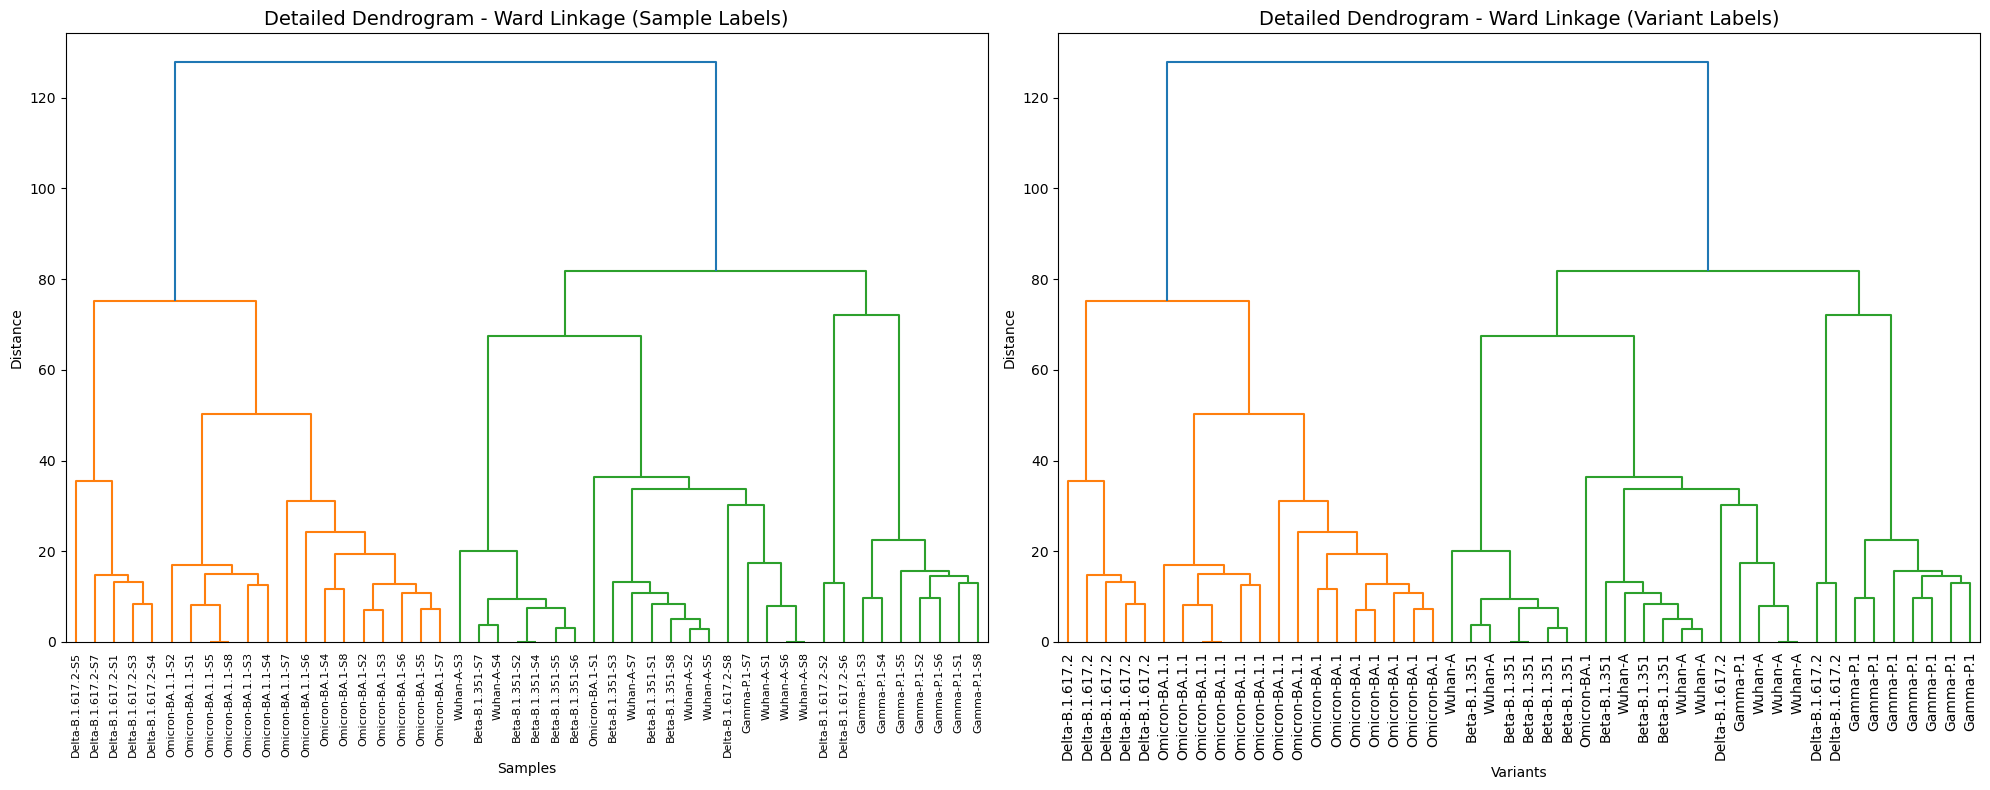

In [8]:
# ============================================================================
# 4. CREATE DETAILED WARD DENDROGRAM
# ============================================================================

print("\n5. Creating detailed Ward dendrogram...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Ward dendrogram with sample labels
distance_matrix = pdist(X_scaled, metric='euclidean')
linkage_matrix = linkage(distance_matrix, method='ward')

# Create dendrogram with sample labels
dendrogram(linkage_matrix, 
          labels=combined_df['sequence'].values,
          ax=ax1,
          orientation='top',
          leaf_rotation=90,
          leaf_font_size=8,
          color_threshold=0.7 * max(linkage_matrix[:, 2]))

ax1.set_title('Detailed Dendrogram - Ward Linkage (Sample Labels)', fontsize=14)
ax1.set_xlabel('Samples')
ax1.set_ylabel('Distance')

# Create dendrogram with variant labels
variant_labels = combined_df['variant'].values
dendrogram(linkage_matrix, 
          labels=variant_labels,
          ax=ax2,
          orientation='top',
          leaf_rotation=90,
          leaf_font_size=10,
          color_threshold=0.7 * max(linkage_matrix[:, 2]))

ax2.set_title('Detailed Dendrogram - Ward Linkage (Variant Labels)', fontsize=14)
ax2.set_xlabel('Variants')
ax2.set_ylabel('Distance')

plt.tight_layout()
plt.show()

The Ward dendrogram is a hierarchical clustering tree that visually represents the similarity relationships among all sequences based on their combined structural angles, mutation profiles, and distance features. In this plot, each leaf at the bottom represents an individual sequence, and branches connect sequences or clusters that are most similar according to Euclidean distance in the normalized feature space. The Ward method merges clusters in a way that minimizes the total variance within clusters at each step, producing compact, well-balanced groupings. The vertical axis shows the linkage distance, which reflects how dissimilar clusters are when they merge; lower merges indicate high similarity, while higher merges indicate more distant relationships. Sequences that cluster together at low heights share highly similar feature patterns, while clusters that merge at higher points are more divergent. By examining where known variants appear, the dendrogram can reveal whether the measured structural and mutational features align with expected biological groupings, or whether convergent patterns emerge across variants. The color threshold applied to the branches highlights distinct clusters, making it easier to see natural divisions in the data. This method is especially useful for detecting subtle structural–sequence relationships that might be overlooked by other clustering techniques.

In this Ward linkage dendrogram, each leaf along the x-axis represents an individual sequence, labeled with its variant and identifier. The Ward method groups sequences in a way that minimizes the variance within each cluster, producing compact, balanced clusters. The vertical axis represents the Euclidean distance in standardized feature space, which combines structural sidechain angles, mutation profiles, and TM-align–based distance features. Sequences that merge at short vertical distances are highly similar in their combined features, while merges at greater heights indicate more substantial differences.

Here, two major clusters are visible: the left (orange) cluster contains primarily Delta (B.1.617.2) and Omicron BA.1.1 sequences, suggesting these share closer structural–mutational similarity to each other than to the sequences in the right (green) cluster. The right cluster groups Wuhan, Beta, Gamma, and some Delta sequences, implying feature overlap across these lineages despite distinct variant classifications. The height of the split between the two main clusters reflects the degree of divergence captured by the features; in this case, the large separation indicates a substantial overall difference between the two groups. By examining such patterns, the dendrogram can reveal relationships among variants that may not align exactly with lineage definitions, hinting at convergent or divergent evolutionary trends.